In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive
# compare ensemble to each standalone models for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
from matplotlib import pyplot
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
path = '/content/drive/My Drive/bt4222code'

In [8]:
df = pd.read_csv(path + '/combined.csv', index_col=0)
df.head()
df = df.reset_index(drop=True)

In [9]:
# Label Encoding 
df['street'] = df['street'].astype('category')
street_dict = dict(zip(df['street'], df['street'].cat.codes))
df['street'] = df['street'].cat.codes

df['propertyType'] = df['propertyType'].astype('category')
property_dict = dict(zip(df['propertyType'], df['propertyType'].cat.codes))
df['propertyType'] = df['propertyType'].cat.codes

df['floor_range'] = df['floor_range'].astype('category')
floor_dict = dict(zip(df['floor_range'], df['floor_range'].cat.codes))
df['floor_range'] = df['floor_range'].cat.codes

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('price', axis=1),
                                                    df['price'], 
                                                    test_size=0.2,
                                                    random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(106952, 14)
(26738, 14)
(106952,)
(26738,)


In [45]:
# built stacking ensemble

# Built level 0 
from lightgbm import LGBMRegressor

def get_all_base_model_corr(X_train, y_train):
  base_models = dict()
  base_models['knn'] = KNeighborsRegressor()
  base_models['lr'] = LinearRegression()
  base_models['cart'] = DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=800, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=15, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')
  base_models['rf'] = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
  base_models['lgbm'] = LGBMRegressor(random_state=42)
  n_df = y_train.reset_index(drop=True)
  for name, model1 in base_models.items():
    model1.fit(X_train, y_train)
    df = pd.DataFrame(model1.predict(X_train), columns=[name])
    n_df = pd.concat([n_df, df], axis=1)
  return n_df.corr(), base_models

model_corr, models_dict = get_all_base_model_corr(X_train, y_train)

In [46]:
model_corr

,price,knn,lr,cart,rf,lgbm
price,1.000000,0.953822,0.881369,0.977211,0.994328,0.971593
knn,0.953822,1.000000,0.915457,0.962073,0.968905,0.965470
lr,0.881369,0.915457,1.000000,0.896919,0.900077,0.903140
cart,0.977211,0.962073,0.896919,1.000000,0.988718,0.978438
rf,0.994328,0.968905,0.900077,0.988718,1.000000,0.984491
lgbm,0.971593,0.965470,0.903140,0.978438,0.984491,1.000000


In [47]:
# CART,RF and LGBM are all tree based and are v correlated, drop LGBM, use CART as Level1 Regressor

In [48]:
# get a stacking ensemble of models
def stacking_regressor(base_models, level0_list, level1):
  level0 = list()
  new_base_models = dict()
  for model in level0_list:
    level0.append((model, base_models[model]))
    new_base_models[model] = base_models[model]
  level1 = base_models[level1]
  model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
  new_base_models['stacking'] = model
  return model, new_base_models

sr, models_dict = stacking_regressor(models_dict, level0_list=['knn','lr', 'cart'], level1='rf')

In [49]:
models_dict

{'cart': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                       max_features=None, max_leaf_nodes=800,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best'),
 'knn': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform'),
 'lr': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 'stacking': StackingRegressor(cv=5,
                   estimators=[('knn',
                                KNeighborsRegressor(algorithm='auto',
                                                    leaf_size=30,
                                                    metric='minkowski',
                          

>knn -408653397033.301 (234525019498.806)
>lr -627730264277.325 (179900410627.519)
>cart -387554959660.038 (299485577040.022)


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


>stacking -303255233120.767 (211439022413.467)


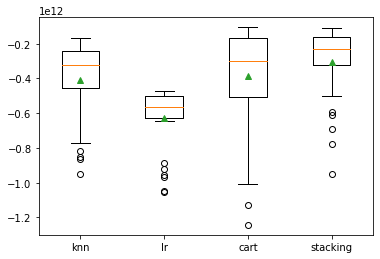

In [50]:
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores

results, names = list(), list()
for name, model in models_dict.items():
	scores = evaluate_model(model, X_train, y_train)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

# Metrics for Ensemble

In [51]:
# Convert both y_train and y_test back to series
y_train = y_train.squeeze()
y_test = y_test.squeeze()

sr.fit(X_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('knn',
                               KNeighborsRegressor(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=5,
                                                   p=2, weights='uniform')),
                              ('lr',
                               LinearRegression(copy_X=True, fit_intercept=True,
                                                n_jobs=None, normalize=False)),
                              ('cart',
                               DecisionTreeRegressor(ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=None,
                                                     max_featu

In [52]:
# Compute MSE
def mse(y_predicted, y_true):
  return np.mean(np.square(y_predicted - y_true))

mse_training = mse(sr.predict(X_train), y_train)
mse_testing = mse(sr.predict(X_test), y_test)

print("training mse: {}, testing mse: {}".format(mse_training, mse_testing))
print("training rmse: {}, testing rmse: {}".format(np.sqrt(mse_training), np.sqrt(mse_testing)))

training mse: 165185081870.65536, testing mse: 120882859345.91333
training rmse: 406429.6764148201, testing rmse: 347682.1239953434


In [53]:

# Compute R2 and adjusted R2
print("training R2: {}, testing R2: {}".format(sr.score(X_train, y_train), sr.score(X_test, y_test)))
print("training adjusted R2: {}, testing adjusted R2: {}".format(
    1 - (1-sr.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1), 
    1 - (1-sr.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)))

training R2: 0.9409812410517813, testing R2: 0.9425699473470747
training adjusted R2: 0.9409735144218471, testing adjusted R2: 0.9425398601286807


In [54]:
# Calculate MAE
print("training MAE: {}, testing MAE: {}".format(
    mean_absolute_error(y_train, sr.predict(X_train)),
    mean_absolute_error(y_test, sr.predict(X_test)),    
))

training MAE: 71462.18157064854, testing MAE: 88176.00017777884


In [55]:
import numpy as np

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

A = np.array(sr.predict(X_test))
F = np.array(y_test)
print(smape(A, F))

6.408172231425783


In [56]:
# save the model to disk
import pickle
filename = '/content/drive/My Drive/bt4222code/finalized_model.sav'
pickle.dump(sr, open(filename, 'wb'))

In [7]:
import pickle

loaded_model = pickle.load(open(path + '/finalized_model.sav', 'rb'))